## Dependencies

### Install following (if not already available in docker container)

```
apt-get install ffmpeg libsm6 libxext6  -y
```

### Install python wrapper

```
pip install opencv-contrib-python
```

### Install OCR package

```
apt install tesseract-ocr
pip install pytesserat
```

### Install 7 segment trained data

Derived from: git clone https://github.com/Shreeshrii/tessdata_ssd
```
cp trained_data/7seg.traineddata /usr/share/tesseract-ocr/4.00/tessdata
cp trained_data/ssd.traineddata /usr/share/tesseract-ocr/4.00/tessdata
cp trained_data/ssd_int.traineddata /usr/share/tesseract-ocr/4.00/tessdata
```
Note: 7seg seems to be best for LCD display.


In [1]:
from ipywidgets import interact
from utils import utils
import cv2
import numpy as np
import pandas as pd
import pytesseract

from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (8.0, 6.0) # this controls figure size in the notebook

img_path = './images/LCD_heating_18.jpeg'

### Thresholding Approach

Work out the best thresholding approach to maximise contour detection and Hough transform line detection. 

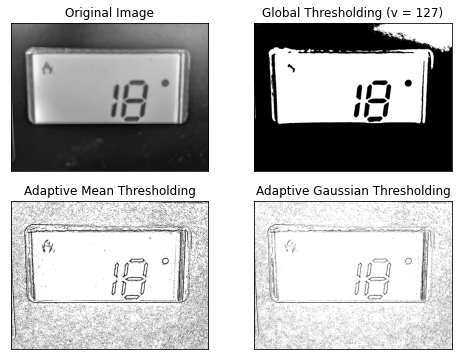

In [2]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_blur = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img_blur,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img_blur, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

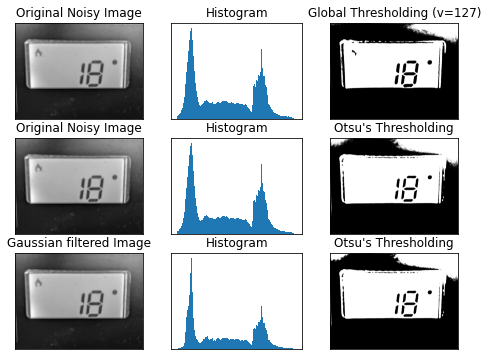

In [3]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# global thresholding
ret1, th1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Otsu's thresholding
ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img, (5,5), 0)
ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]

titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

### Edge Detection

Canny edge detect.

In [4]:
def canny(Value):
    edges = cv2.Canny(th3, Value, 200, 255)
    plt.imshow(edges, cmap = 'gray')
    plt.title('Canny Edge Detection')
    
interact(canny,Value=(1,255,2))

edges = cv2.Canny(th3, 127, 200, 255)

interactive(children=(IntSlider(value=127, description='Value', max=255, min=1, step=2), Output()), _dom_class…

### Find and filter contours

Use Hu moments of contours to select and filter 7 segment elements. Hu moments are invariant to scale, translation and rotation.

,m1,m2,m3,m4,m5,m6,m7
0,0.313325,0.071562,0.000017,0.000006,0.0,0.000002,-0.0
1,0.318208,0.073588,0.000482,0.000052,-0.0,-0.000007,-0.0
2,0.303151,0.064793,0.000237,0.000081,0.0,0.000014,-0.0
3,0.304812,0.065887,0.000316,0.000105,0.0,0.000016,-0.0
4,0.380718,0.118919,0.000043,0.00001,0.0,0.000001,0.0
5,0.314912,0.072204,0.000185,0.000023,-0.0,-0.000003,-0.0
6,0.31295,0.070556,0.00054,0.000051,-0.0,-0.000013,-0.0
7,0.319868,0.075067,0.000208,0.000021,-0.0,-0.000003,-0.0
8,0.341739,0.089982,0.000084,0.000049,0.0,0.000014,0.0


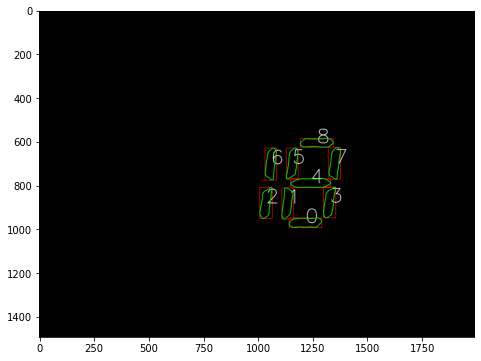

In [5]:
# Find contours
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Create blank image of same size as source image
d = img.shape
blank_image = np.zeros((d[0], d[1], 3), np.uint8)

# Get contours
#RETR_TREE
#RETR_EXTERNAL - best
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Contours that match a 7 segment element
filtered_contours = []

# Dataframe of Hu moments
df = pd.DataFrame(columns=["m1", "m2", "m3", "m4", "m5", "m6", "m7"])

i = 0
# Eliminate non seven segment contours
for cnt in contours:
    approx = cv2.contourArea(cnt)
    if (approx > 4000):    # FIXME: 
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(blank_image,(x,y),(x+w,y+h),(255,0,0),2)
        cv2.putText(blank_image, str(i), (x+int(w/2),y+int(h/2)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 2, cv2.LINE_AA)
        i = i + 1
        M = cv2.moments(cnt)
        huM = cv2.HuMoments(M).flatten()
        entry = pd.DataFrame.from_dict({
             "m1": [ huM[0] ],
             "m2": [ huM[1] ],
             "m3": [ huM[2] ],
             "m4": [ huM[3] ],
             "m5": [ huM[4] ],
             "m6": [ huM[5] ],
             "m7": [ huM[6] ]
        })
        
        df = pd.concat([df, entry], ignore_index=True)
        filtered_contours.append(cnt)

cv2.drawContours(image=blank_image, contours=filtered_contours, contourIdx=-1, 
                 color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.imshow(blank_image)
df.style.set_caption("Hello World")
df

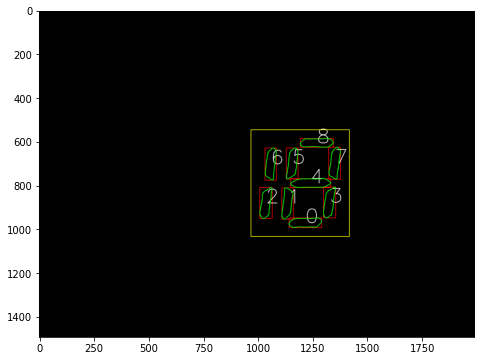

In [6]:
# Find bounding box for all 7 segment contours
x1, y1, x2, y2 = utils.boundingRectForContours(filtered_contours)

cv2.rectangle(blank_image,(x1,y1),(x2,y2),(255,255,0),2)
plt.imshow(blank_image)

(1492, 1990)
967 546 1416 1033


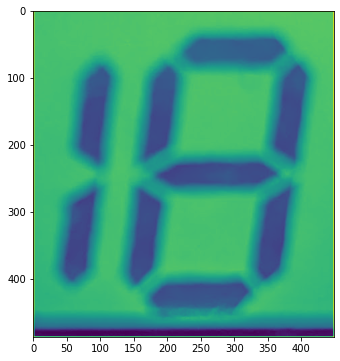

In [7]:
# Segment image
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print (img.shape)

print (x1, y1, x2, y2)
h = y2 - y1
w = x2 - x1
cropped_image = img[y1:y1+h, x1:x1+w]

cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,0),2)
plt.imshow(img)
plt.imshow(cropped_image)

## OCR Segmented Image

Use Tesseract to OCR the segmented image. The trained data set used is specific for 7 segments.

In [8]:
# OCR
d = pytesseract.image_to_string(cropped_image, config="-l 7seg --psm 8") # best
#d = pytesseract.image_to_string(thr, config="-l ssd_int --psm 8")
#d = pytesseract.image_to_string(thr, config="-l 7seg --psm 8")
print(d)

18

